# Land use and Land Cover Classification

The availability of free satellite data has increased its use in several applications in the domains of agriculture, disaster recovery, climate change, urban development, or environmental monitoring can be realized. However, to fully utilize the data for the previously mentioned domains, first satellite images must be processed and transformed into structured semantics. One type of such fundamental semantics is Land Use and Land Cover Classification. The aim of land use and land cover classification is to automatically provide labels describing the represented physical land type or how a land area is used (e.g., residential, industrial)

A satellite image dataset for the task of land use and land cover classification was presented in [[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8519248). The EuroSAT dataset is based on Sentinel-2 satellite images and consists of 27,000 labeled images with a total of 10 different classes listed below where the patches are 64x64 pixels each.

![alt text](./Images/dataset.png "The EuroSAT Dataset")

In this assignment you are going to use the optical bands of Sentinel-2 which are computed by combining the bands red (B04), green (B03) and blue (B02) from the Sentinel-2 product. More information about the Sentinel-2 bands can be found [here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial). You will then train different Convolutional Neural Network (CNN) models to classify every 64x64 patches in one of the following classes:

1. AnnualCrop
2. Forest
3. Herbaceous Vegetation
4. Highway
5. Industrial
6. Pasture
7. Permanent Crop
8. Residential
9. River
10. SeaLake



## Instructions
The EuroSAT dataset is based on Sentinel-2 satellite images and consists of 27,000 labeled images with a total of 10 different classes. The dataset is structured as follows:
1. `train.txt`: this file contains a list of images that will be used to train the Convolutional Neural Network (CNN) models.
2. `test.txt`: this file contains a list of images that will be used to test the Convolutional Neural Network (CNN) models.
3. A list of 10 folders, each one containing the images pertaining to each class.

All code needs to be developed in Python 3 and run on a Ubuntu 20.04 environment or later versions of Ubuntu. The student is requested send the jupyter notebook using the template provided. Any textual or visual information and equations that the student might need to convey is expected to be written using the markdown language within the same Juputer Notebook. The Juputer Notebook should be named as follows

`name-surname.ipynb`

The list of packages that are allowed for this assignment are: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `torchvision` and any other packages agreed with the lecturer.


## Assignment

**Q1:** A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initializes the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get i-th sample.


Write a class `DataLoaderClassification` that can be used to
- load the list of image filenames and the corresponding lables in two lists in `__init__`
- load a batch of images and corresponding lables when one calls `__getitem__`
- returns the length of the dataset using `__len__`

Write the code in one or more cells.

In [186]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


Debug = True # Used to control the prints

In [187]:
####################################################################
#  DataLoaderClassification() ::    Custom Dataset method          #
####################################################################
class DataLoaderClassification(Dataset):
    def __init__(self, data_dir, file_list_path):
        # Args:
        #    data_dir :: Path to the directory containing image subfolders.
        #    file_list_path :: Path to the text file containing image paths (e.g., train.txt or test.txt).

        self.data_dir = data_dir        
        self.image_paths = []
        self.labels = []
        
        # A set to collect unique labels
        label_set = set()
        
        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')  
                    self.image_paths.append(updated_path)
                    
                    label = os.path.split(updated_path)[0].replace('./Data/', '')  
                    self.labels.append(label)
                    label_set.add(label)  # Collect unique labels
                    
        # Create a mapping from label strings to integers
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# Convert to RGB

        # image to tensor
        transform = transforms.ToTensor()
        image = transform(image)
        
        # Convert label from string to integer using the label mapping and, then, to tensor
        label = self.label_to_index[label]
        label = torch.tensor(label)
        
        return image, label

The custom DataLoaderClassification class is used to initialize the collection of data.
Afterwards, in **Q2**, the DataLoader iterates over train_dataset and test_dataset to provide batches of data. 

Our custom Dataset defines how we access and return individual samples (or sample-label pairs) and the DataLoader uses the Dataset as source.

In [188]:
data_dir = 'Data'
train_file_list = 'Data/train.txt'
test_file_list = 'Data/test.txt'

train_dataset = DataLoaderClassification(data_dir=data_dir, file_list_path=train_file_list)
test_dataset  = DataLoaderClassification(data_dir=data_dir, file_list_path=test_file_list)

print(f"Number of items in train_dataset: {len(train_dataset)}")
print(f"Number of items in test_dataset: {len(test_dataset)}")


# Testing getitem()
if Debug:
    test_index = random.randint(0, 21599)
    print(f"Check item {test_index} from train_dataset")
    image, label = train_dataset[test_index]
    print(f"Image {test_index} -> Shape: {image.shape}, Label: {label}")

Number of items in train_dataset: 21600
Number of items in test_dataset: 5400
Check item 20149 from train_dataset
Image 20149 -> Shape: torch.Size([3, 64, 64]), Label: 6


**Q2:** Write the code in one cell that uses the list of files included in `train.txt` and `test.txt` to create a Pytorch dataloader for the training and testing data, respectively.

**Loading in batches**

DataLoader: Shuffling while training to prevent learning parterns related to the order.
When testing, shuffling is typically set to False to maintain the order of the test samples.

In [189]:
#num_workers = 0   # number of subprocesses to use for data loading (for paralelization)
batch_size = 20    # how many samples per batch to load

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



######
# print_batches :: Debugger function
#######
def print_batches(loader, batchtype = "", maxshow=1, Debug=False):
    if Debug:
        for batch_idx, (images, labels) in enumerate(loader):
            print(f"\n {batchtype} batch {batch_idx + 1}  \n   Image batch shape: {images.shape}, \n   Labels: {labels}")
            if batch_idx == maxshow:
                break
        print(f"\n{batchtype} data type (images): {images.dtype}, Data type (labels): {labels.dtype}\n")
                
print_batches(train_loader, "Train", Debug=False)
print_batches(test_loader, "Test", Debug=False)

Note that since the suffle is on for the train sample, calling twice the print_batches(train_loader) debugger will provide different prints. This is not the case for test_loader because shuffle=False.

**Q3:** PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output. Write the `CNN` class to define a Convolutional Neural Network (CNN) where the first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5. The output of `conv1` is fed into a ReLU followed by a Max-pooling operator. The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5 followed by a ReLU and a max-pooling operator. The last layer is a fully-connected layer (`fc1`) with 10 output neurons. In this code you should define the `__init__` and `forward` member functions.

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

In [190]:
###############################################
#  SimpleCNN() :: Arquitecture defined in Q3 #
###############################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 13 * 13, out_features=10)

    def forward(self, x):
                                                     # --> 64x64x3 -->
        x = F.relu(self.conv1(x))                    # --> 16x60x60 (conv1 kernel_size=5 without padding)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # --> 16x30x30 
        x = F.relu(self.conv2(x))                    # --> 32x26x26 (conv2 kernel_size=5 without padding)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # --> 32x13x13
        x = x.view(-1, 32 * 13 * 13)                 # --> 1x5408
        x = self.fc1(x)                              # --> 1x10
        return x
    


Pooling with kernel size of 2 and stride of 2 (typicall choice) -> downsamples the feature map by a factor of 2

<!-- Pooling is a down-sampling operation used in CNNs to reduce the spatial dimensions (width and height) of the feature maps while retaining the most important information.  -->

**Q4:** Write the code in one or more cells to train the CNN specified in **Q3**. Plot the accuracy against the number of epochs.  Save the best performing model in the folder `./Model/Simple-CNN/model.pth` and print the highest accuracy achieved after 100 epochs using the markdown language.

In [191]:
train_on_gpu = torch.cuda.is_available() # I have an M3, so no cuda for me 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device = 'gpu'
    
model = SimpleCNN()
print(model)

# move tensors to GPU if CUDA is available
model.to(device)

CUDA is not available.  Training on CPU ...
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=10, bias=True)
)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=10, bias=True)
)

In [192]:
# split train in validation + train
valid_size = 0.2  # percentage of training set to use as validation

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)



print_batches(train_loader,"Train", Debug=Debug)
print_batches(valid_loader,"Validation", Debug=Debug)
print_batches(test_loader, "Test", Debug=Debug)

                
                
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer. The most popular optimizers are Adam and SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)            # Stochastic Gradient Descent
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Adaptive Moment Estimation


# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


# Number of epochs to train the model
n_epochs = 40



 Train batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([8, 7, 1, 8, 7, 0, 7, 4, 1, 6, 0, 2, 3, 7, 2, 3, 1, 7, 9, 5])

 Train batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([5, 5, 2, 1, 0, 2, 5, 7, 0, 4, 0, 6, 9, 5, 6, 7, 6, 9, 8, 9])

Train data type (images): torch.float32, Data type (labels): torch.int64


 Validation batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([9, 7, 0, 9, 8, 4, 7, 1, 8, 0, 2, 3, 0, 9, 0, 0, 3, 6, 3, 4])

 Validation batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([0, 5, 5, 5, 4, 3, 2, 7, 3, 9, 1, 9, 2, 5, 1, 5, 0, 9, 8, 3])

Validation data type (images): torch.float32, Data type (labels): torch.int64


 Test batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([2, 3, 7, 7, 0, 0, 0, 4, 2, 4, 0, 9, 9, 9, 4, 9, 3, 6, 9, 8])

 Test batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor

In [193]:
#####################################################################################################################
#  train_model() :: Training function                                                                               #
#      patience   :: Training will stop if no significant improvement takes place in "patience" epochs.             #
#      threshold  :: Relative improvement required for validation acc or loss to reset the patience counter.        #
#####################################################################################################################
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler, patience=20, threshold=0.15, save_path="./Model/Simple-CNN/", save_name ="model.pth"):
    
    # Keep track of training and validation loss
    valid_accuracy_max = 0                       # Itinizalize max validation accuracy
    valid_loss_min = np.Inf                      # Initialize minimum validation loss
    train_losses, valid_losses = [], []          # Store loss values for plotting
    train_accuracies, valid_accuracies = [], []  # Store accuracy values for plotting
    no_improvement_epochs = 0                    # Initialize patience counter

    for epoch in range(1, num_epochs+1):

        ###################
        # train the model # --> train_loader
        ###################
        model.train()  # Set the model to training mode
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        total_train = 0        
        
        # Training phase
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()               # Clear the gradients
            output = model(images)              # Forward pass, calculate ouput
            loss = criterion(output, labels)    # Calculate the loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update weights

            train_loss += loss.item() * images.size(0)  # Track training loss
            
            _, predicted = torch.max(output, 1)  # Get predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        ######################
        # validate the model # --> valid_loader
        ######################
        model.eval()  # Set the model to evaluation mode
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()

                output = model(images)                      # Forward pass
                loss = criterion(output, labels)            # Calculate the validation loss
                
                valid_loss += loss.item() * images.size(0)   # Track validation loss

                _, predicted = torch.max(output, 1)         # Get predicted class
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)
        
        ###################
        #  Derive metrics #
        ###################
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
        #train_loss = train_loss / len(train_loader)  
        #valid_loss = valid_loss / len(valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Calculate training and validation accuracy
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid
        
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Print training/validation statistics
        print(f'\nEpoch: {epoch} \n\tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \n\tTraining Accuracy: {train_accuracy:.2f}% \tValidation Accuracy: {valid_accuracy:.2f}%')

        #####
        # Save the model if validation loss has decreased
        ######
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_full_path = os.path.join(save_path, save_name)
        
        if valid_loss < valid_loss_min:  
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_full_path)
            valid_loss_min = valid_loss
            #valid_accuracy_max = valid_accuracy
            
            
        ####
        # Early stop
        ### 
        relative_loss_improvement = (valid_loss_min - valid_loss) / valid_loss_min if valid_loss_min != 0 else 0
        relative_accuracy_improvement = (valid_accuracy - valid_accuracy_max) / valid_accuracy_max if valid_accuracy_max != 0 else 0


        # Check if loss and accuracy improved by more than the threshold
        if (relative_loss_improvement > threshold) or (relative_accuracy_improvement > threshold):
            valid_accuracy_max = valid_accuracy
            no_improvement_epochs = 0  # Reset patience counter 
        else:
            no_improvement_epochs += 1
        
        # Adjust learning rate based on validation loss
        scheduler.step(valid_loss)
        
        if no_improvement_epochs >= patience:
            print(f'Early stopping: No improvement in validation for {patience} epochs.')
            break  

    return train_losses, valid_losses, train_accuracies, valid_accuracies



 


In [194]:
# RUN TRAINING
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=n_epochs, scheduler=scheduler)



Epoch: 1 
	Training Loss: 1.811866 	Validation Loss: 1.632649 
	Training Accuracy: 29.86% 	Validation Accuracy: 41.53%
Validation loss decreased (inf --> 1.632649). Saving model ...

Epoch: 2 
	Training Loss: 1.518737 	Validation Loss: 1.324507 
	Training Accuracy: 43.20% 	Validation Accuracy: 53.01%
Validation loss decreased (1.632649 --> 1.324507). Saving model ...

Epoch: 3 
	Training Loss: 1.347484 	Validation Loss: 1.378146 
	Training Accuracy: 51.36% 	Validation Accuracy: 51.92%

Epoch: 4 
	Training Loss: 1.165887 	Validation Loss: 1.066361 
	Training Accuracy: 58.12% 	Validation Accuracy: 60.37%
Validation loss decreased (1.324507 --> 1.066361). Saving model ...

Epoch: 5 
	Training Loss: 0.990862 	Validation Loss: 1.029147 
	Training Accuracy: 64.76% 	Validation Accuracy: 62.55%
Validation loss decreased (1.066361 --> 1.029147). Saving model ...

Epoch: 6 
	Training Loss: 0.866302 	Validation Loss: 0.906055 
	Training Accuracy: 69.47% 	Validation Accuracy: 66.99%
Validation lo

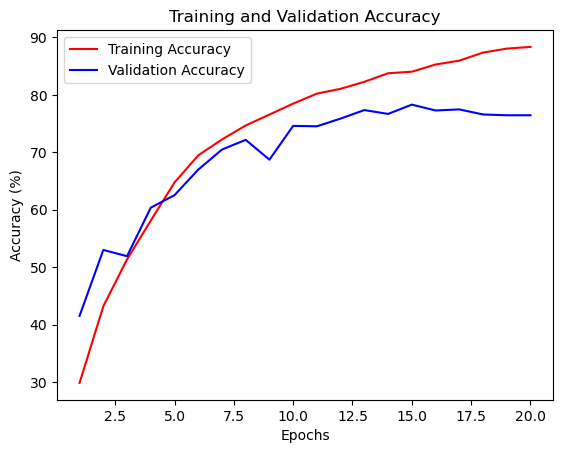

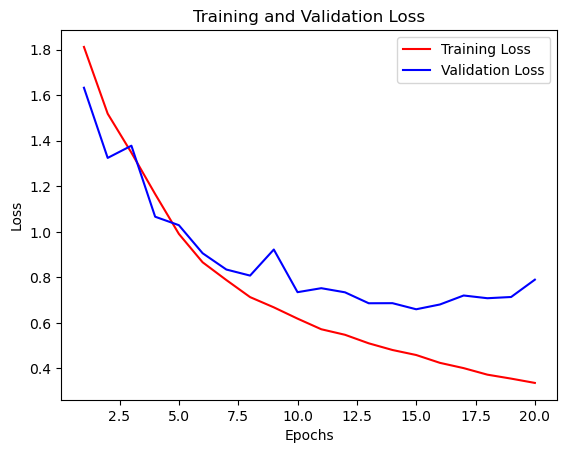

In [195]:
# Plot accuracy vs epochs
# Plot training and validation accuracy
def plot_accuracy(train_accuracies, valid_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # defined like this for the event of early stopping
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Plot training and validation loss
def plot_loss(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)  
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot accuracy and loss
plot_accuracy(train_accuracies, valid_accuracies)
plot_loss(train_losses, valid_losses)



To avoid overfitting, an early stop criteria has been applied.

We use the test sample (which has not been seen by the training at any point) to evaluate the models performance.

In [196]:
def test_model(model, test_loader, criterion):
    # Load the best model weights (assuming they are saved in 'model.pth')
    model.load_state_dict(torch.load('./Model/Simple-CNN/model.pth'))
    
    # Set the model to evaluation mode
    model.eval()
    
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    # Turn off gradients for test evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # Forward pass: compute predictions
            output = model(images)
            
            # Calculate the test loss
            loss = criterion(output, labels)
            test_loss += loss.item() * images.size(0)  # Accumulate the test loss
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)  # Get predicted class
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    # Calculate average test loss
    test_loss = test_loss / len(test_loader.sampler)
    
    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test
    
    print(f'\nTest Loss: {test_loss:.6f} \nTest Accuracy: {test_accuracy:.2f}%')


    


In [197]:
test_model(model, test_loader, criterion)


Test Loss: 0.634401 
Test Accuracy: 78.19%


**Q5:** Your role as a researcher is to improve the performance of the current neural network. Explain the architecture that provided the best performance and describe the modifications that you think provided the gain.
    

### 5.1 Data augmentation
First, I would add data augmentation in the dataset pipeline to make the model more robust.

To do so we use transformations.
 -  RandomHorizontalFlip(): Flips the image horizontally with a probability of 50%.
 -  RandomRotation(20): Applies a random rotation to the image within a range of ±10 degrees. This helps the model become more invariant to small rotations in the input images, improving robustness.
 
The we redefine the old DataLoaderClassification() so that it works with transformation.
Then, in the training stage, the transformations are used to augment the data.
Note that we are not augmenting the size of the dataset explicitally, the data is augmented (applying random transforamtions to the images) on the fly during each epoch.

In [178]:
from PIL import Image
# Data transformation with augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


########################################################
#  DataLoaderClassification_improved :: Dataset Class  #
########################################################
class DataLoaderClassification_improved(Dataset):
    def __init__(self, data_dir, file_list_path, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        label_set = set()
        
        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')
                    self.image_paths.append(updated_path)
                    
                    label = os.path.split(updated_path)[0].replace('./Data/', '')
                    self.labels.append(label)
                    label_set.add(label)
                    
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]

        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply transform if provided
        if self.transform:
            image = Image.fromarray(image)  # Convert image to PIL Image for compatibility with torchvision.transforms
            image = self.transform(image)
        else:
            # Default: Convert to tensor if no transform is provided
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            image = transform(image)

        
        label = self.label_to_index[label]
        label = torch.tensor(label)
        
        return image, label
    
train_dataset_new = DataLoaderClassification_improved(data_dir=data_dir, file_list_path=train_file_list, transform=transform)
test_dataset_new = DataLoaderClassification_improved(data_dir=data_dir, file_list_path=test_file_list, transform=None)

print(f"Number of items in train_dataset_new: {len(train_dataset_new)}")
print(f"Number of items in test_dataset_new: {len(test_dataset_new)}")


print("\nSplit the train in train + validation")
# split train in validation + train
train_sampler_new = SubsetRandomSampler(train_idx)
valid_sampler_new = SubsetRandomSampler(valid_idx)

# Load data en batches
batch_size = 20

train_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, sampler=train_sampler_new)
valid_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, sampler=valid_sampler_new)
test_loader_new = DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

if Debug:
    print(f"\n  Samples in train_loader: {len(train_loader.sampler)}")
    print(f"  Batches in train_loader: {len(train_loader)}")

    print(f"\n  Samples in valid_loader: {len(valid_loader.sampler)}")
    print(f"  Batches in valid_loader: {len(valid_loader)}")

    print(f"\n  Samples in test_loader: {len(test_loader.dataset)}")
    print(f"  Batches in test_loader: {len(test_loader)}")
    

print_batches(train_loader_new,"Train", Debug=False)
print_batches(valid_loader_new,"Validation", Debug=False)
print_batches(test_loader_new,"Test", Debug=False)


Number of items in train_dataset_new: 21600
Number of items in test_dataset_new: 5400

Split the train in train + validation

  Samples in train_loader: 17280
  Batches in train_loader: 864

  Samples in valid_loader: 4320
  Batches in valid_loader: 216

  Samples in test_loader: 5400
  Batches in test_loader: 270


Let's train the same SimpleCNN model but this time we will be using the data augmentation.

In [151]:
model_new = SimpleCNN()
#print(model)
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(initialize_weights)
model_new.to(device)

 
    
train_losses_new, valid_losses_new, train_accuracies_new, valid_accuracies_new = train_model(
    model_new, train_loader_new, valid_loader_new, 
    criterion, optimizer, num_epochs=n_epochs, scheduler=scheduler,
    patience=20, threshold=0.005, 
    save_path="./Model/Simple-CNN/", save_name="model_with_augmented_data.pth"
)




Epoch: 1 
	Training Loss: 2.314473 	Validation Loss: 2.317774 
	Training Accuracy: 10.28% 	Validation Accuracy: 10.14%
Validation loss decreased (inf --> 2.317774). Saving model ...

Epoch: 2 
	Training Loss: 2.314203 	Validation Loss: 2.318612 
	Training Accuracy: 10.10% 	Validation Accuracy: 10.16%

Epoch: 3 
	Training Loss: 2.314383 	Validation Loss: 2.317991 
	Training Accuracy: 9.72% 	Validation Accuracy: 9.98%

Epoch: 4 
	Training Loss: 2.314360 	Validation Loss: 2.318273 
	Training Accuracy: 9.89% 	Validation Accuracy: 10.12%

Epoch: 5 
	Training Loss: 2.314076 	Validation Loss: 2.318677 
	Training Accuracy: 9.99% 	Validation Accuracy: 10.32%

Epoch: 6 
	Training Loss: 2.314673 	Validation Loss: 2.317456 
	Training Accuracy: 10.06% 	Validation Accuracy: 10.81%
Validation loss decreased (2.317774 --> 2.317456). Saving model ...

Epoch: 7 
	Training Loss: 2.314706 	Validation Loss: 2.318231 
	Training Accuracy: 10.10% 	Validation Accuracy: 10.69%

Epoch: 8 
	Training Loss: 2.3143

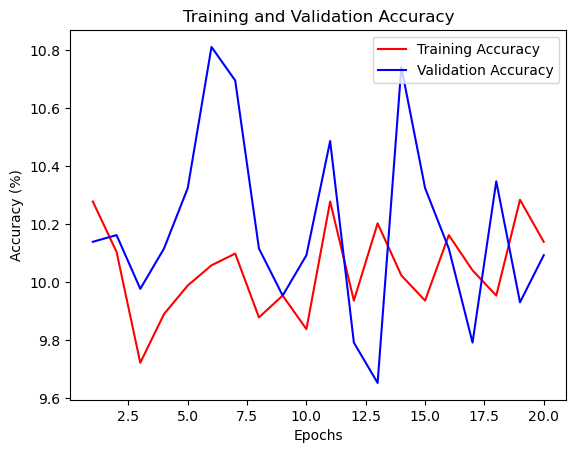

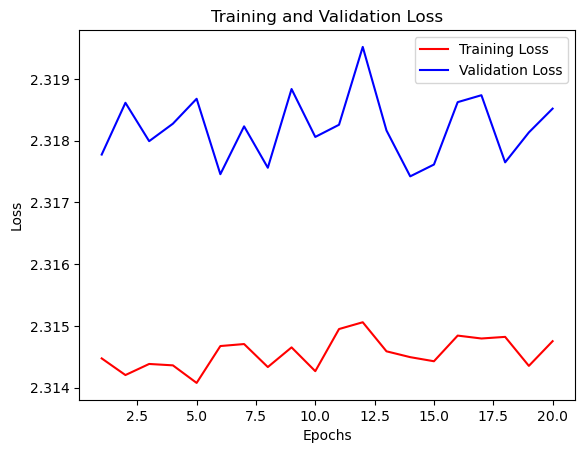

In [180]:
plot_accuracy(train_accuracies_new, valid_accuracies_new)
plot_loss(train_losses_new, valid_losses_new)

### 5.2 Define the improved CNN

Now we improve the architecture of the Simple CNN by increasing the depth and complexity of the network. First, we add batch normalization (bn1, bn2, bn3, and bn4) after each of the convolutional layers (conv1, conv2, conv3, and conv4). Batch normalization normalizes the output of each layer to have zero mean and unit variance across the batch, which helps stabilize the learning process and makes the network less sensitive to weight initialization. Placing batch normalization after the convolution layers ensures that the activations fed into the next layer are properly scaled and normalized.


Additionally, we increase the number of convolutional layers from two to four, allowing the network to capture more complex and hierarchical features from the input images. We also increase the number of filters in each convolutional layer (32, 64, 128, 256), progressively extracting more detailed features as the network deepens. Using 3x3 kernels with padding ensures that the spatial dimensions of the feature maps are preserved after each convolution, while max pooling reduces the spatial size, allowing for translation invariance and computational efficiency.


We introduce global average pooling before the fully connected layers, replacing the flattening operation. Global average pooling reduces each feature map to a single value, which drastically reduces the number of parameters and improves generalization by preventing overfitting. It also allows the network to handle varying input sizes better.



Then, a dropout layer is added before the final output layer. Dropout is used to prevent overfitting by randomly "dropping out" (i.e., ignoring) a subset of the neurons during each forward pass, effectively forcing the model to learn redundant representations. Dropout is typically applied to fully connected layers as these layers often have the most parameters, making them more prone to overfitting.

In [198]:
###############################################
#  impoved_CNN() :: defined form SimpleCNN    #
###############################################
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 3x3 kernel, padding to preserve size
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Increase number of filters
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth Convolutional Layer (Optional)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Global Average Pooling (instead of Flatten)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)  # Match input to output channels of the last conv layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Final output for 10 classes

        # Dropout Layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Reduce size by half

        # Second Convolutional Block
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Third Convolutional Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Fourth Convolutional Block (Optional)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Global Average Pooling
        x = self.global_avg_pool(x)  # Reduces to (batch_size, 256, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout for regularization
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer
        
        return x
    
    
model = impoved_CNN()
print(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
n_epochs = 40

impoved_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [199]:
train_losses_imp, valid_losses_imp, train_accuracies_imp, valid_accuracies_imp = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=n_epochs, 
    scheduler=scheduler, patience=30, threshold=0.005, 
    save_path="./Model/Improved-CNN/", save_name="model_01.pth"
)


Epoch: 1 
	Training Loss: 1.326658 	Validation Loss: 1.614932 
	Training Accuracy: 51.72% 	Validation Accuracy: 49.31%
Validation loss decreased (inf --> 1.614932). Saving model ...

Epoch: 2 
	Training Loss: 1.024643 	Validation Loss: 0.819572 
	Training Accuracy: 62.93% 	Validation Accuracy: 69.56%
Validation loss decreased (1.614932 --> 0.819572). Saving model ...

Epoch: 3 
	Training Loss: 0.888856 	Validation Loss: 0.810633 
	Training Accuracy: 68.48% 	Validation Accuracy: 70.88%
Validation loss decreased (0.819572 --> 0.810633). Saving model ...

Epoch: 4 
	Training Loss: 0.828729 	Validation Loss: 2.651836 
	Training Accuracy: 71.04% 	Validation Accuracy: 39.86%

Epoch: 5 
	Training Loss: 0.768975 	Validation Loss: 0.866634 
	Training Accuracy: 73.14% 	Validation Accuracy: 66.67%

Epoch: 6 
	Training Loss: 0.731962 	Validation Loss: 1.646585 
	Training Accuracy: 74.16% 	Validation Accuracy: 52.64%

Epoch: 7 
	Training Loss: 0.683654 	Validation Loss: 0.586628 
	Training Accurac

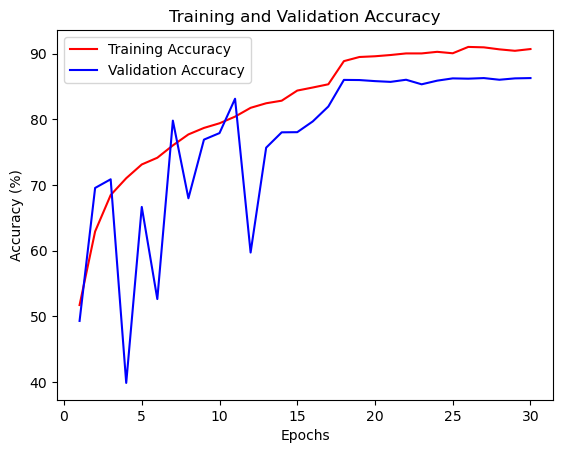

In [200]:
plot_accuracy(train_accuracies_imp, valid_accuracies_imp)

As expected, the training accuracy increases steadily throughout the training process, reaching arround 85%. The validation accuracy increases rapidly in the early epochs, which is good, but it starts to fluctuate after about 10 epochs. After the initial jump, the validation accuracy remains relatively stable, staying close to the training accuracy with minor oscillations. This activated the early stop.

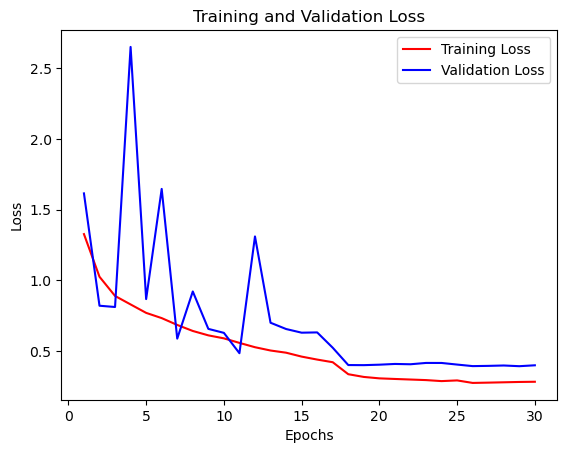

In [201]:
plot_loss(train_losses_imp, valid_losses_imp)

The training loss decreases consistently over time, as expected, which indicates that the model is minimizing the error on the training set.

The validation loss decreases rapidly at first but shows a few spikes early on before stabilizing. This behavior is not unusual in the early stages of training, as the model is adjusting to the validation data.
From around 9 epochs onward, the validation loss stabilizes, with minor fluctuations, suggesting that the model has learned the general patterns in the data without overfitting too much.

In [203]:
test_model(model, test_loader, criterion)

RuntimeError: Error(s) in loading state_dict for impoved_CNN:
	Missing key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "fc2.weight", "fc2.bias". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([10, 5408]) from checkpoint, the shape in current model is torch.Size([128, 5408]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([128]).

## Q5 Alternative Approach :: Use Transfer Learning with Tensorflow.keras to train a ResNet-50


Transfer learning is the reuse of a pre-trained model on a new problem. In this case I am using ResNet-50, a very popular CNN that excels at image classification. I'm replacing the last fully connected layer to match the number of labels.

In [30]:
# with tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

import json
import pickle


resnet = ResNet50(input_shape=[64, 64] + [3], weights='imagenet', include_top=False)


In [31]:
##########################################################
#  DataLoaderClassification_Tensorflow() ::              #
##########################################################
class DataLoaderClassification_Tensorflow:
    def __init__(self, data_dir, file_list_path, img_size=(64, 64), num_classes=10):
        self.data_dir = data_dir
        self.image_paths = []
        self.labels = []
        self.img_size = img_size  
        self.num_classes = num_classes 

        label_set = set()

        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')
                    self.image_paths.append(updated_path)

                    label = os.path.split(updated_path)[0].replace('./Data/', '')
                    self.labels.append(label)
                    label_set.add(label)

        # Create a mapping from label strings to integers
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read and preprocess image
        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
        
        # Resize the image to the expected size (64x64x3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = cv2.resize(image, self.img_size)  
        image = image / 255.0  # Normalize to [0, 1] range

        # Convert label from string to integer using the label mapping
        label = self.label_to_index[label]

        # One-hot encode the label
        label = to_categorical(label, num_classes=self.num_classes)

        # Return image in (64, 64, 3) format
        return np.array(image), np.array(label)
    
    
    
##########################################################
#  DataGenerator_Tensorflow() ::                         #
##########################################################
class DataGenerator_Tensorflow(Sequence):
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        # Generate batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        images = []
        labels = []
        for idx in batch_indexes:
            image, label = self.dataset[idx]
            images.append(image)
            labels.append(label)

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            


train_dataset_tf = DataLoaderClassification_Tensorflow(data_dir=data_dir, file_list_path=train_file_list)
test_dataset_tf = DataLoaderClassification_Tensorflow(data_dir=data_dir, file_list_path=test_file_list)

            
train_loader_tf = DataGenerator_Tensorflow(train_dataset_tf, batch_size=32)
valid_loader_tf = DataGenerator_Tensorflow(test_dataset_tf, batch_size=32)


If we want to be strict, the test_dataset_tf should not be used for validation during training. Instead, the validation dataset should be derived from the train_dataset_tf, as we did with the SimpleCNN model. Once the final model is trained, its performance should be evaluated on the test_dataset_tf.

In [32]:
# Freeze the pre-trained ResNet50 layers
for layer in resnet.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = Flatten()(resnet.output)
n_classes = 10
prediction = Dense(n_classes, activation='softmax')(x)

# Create the model with a custom name
model_ResNet50 = Model(inputs=resnet.input, outputs=prediction, name="model_ResNet50")

# Print the model summary to verify the architecture and the name
model_ResNet50.summary()

# Compile the model
model_ResNet50.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



Model: "model_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,669,642 (90.29 MB)

 Trainable params: 81,930 (320.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [33]:
ReTrain = True

save_tf_model = './Model/TF_ResNet50/model_ResNet50.keras'
save_tf_history = './Model/TF_ResNet50/training_history.pkl'
    
if ReTrain == True:
    steps_per_epoch = len(train_dataset) // batch_size
    validation_steps = len(test_dataset)  // batch_size

    n_epochs_tf = 100
    # Fit the model using the data loaders
    r = model_ResNet50.fit(
      train_loader_tf,
      validation_data=valid_loader_tf,
      epochs=n_epochs_tf,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps
    )
    
    
    print(f"Saving model in {save_tf_model}")
    model_ResNet50.save(save_tf_model)
    
    print(f"Saving history in {save_tf_history}")
    with open(save_tf_history, 'wb') as f:
        pickle.dump(r, f)

Epoch 1/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 53ms/step - accuracy: 0.2746 - loss: 2.0399 - val_accuracy: 0.3491 - val_loss: 1.7644
Epoch 2/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.3883 - loss: 1.7216 - val_accuracy: 0.4020 - val_loss: 1.6345
Epoch 3/100
   2/1080 ━━━━━━━━━━━━━━━━━━━━ 1:13 68ms/step - accuracy: 0.3828 - loss: 1.6370 

2024-09-09 20:26:19.997771: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.4314 - loss: 1.6103 - val_accuracy: 0.4269 - val_loss: 1.5560
Epoch 4/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - accuracy: 0.4385 - loss: 1.5481 - val_accuracy: 0.5233 - val_loss: 1.4895
Epoch 5/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.4642 - loss: 1.4991 - val_accuracy: 0.4673 - val_loss: 1.4646
Epoch 6/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - accuracy: 0.4733 - loss: 1.4636 - val_accuracy: 0.4993 - val_loss: 1.4463
Epoch 7/100
   2/1080 ━━━━━━━━━━━━━━━━━━━━ 1:10 66ms/step - accuracy: 0.4844 - loss: 1.4518 

2024-09-09 20:30:12.063294: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.4883 - loss: 1.4317 - val_accuracy: 0.4775 - val_loss: 1.4223
Epoch 8/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.5041 - loss: 1.4013 - val_accuracy: 0.4981 - val_loss: 1.3913
Epoch 9/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.5073 - loss: 1.3894 - val_accuracy: 0.5132 - val_loss: 1.3859
Epoch 10/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.5135 - loss: 1.3745 - val_accuracy: 0.5292 - val_loss: 1.3569
Epoch 11/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5227 - loss: 1.3605 - val_accuracy: 0.5419 - val_loss: 1.3183
Epoch 12/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5236 - loss: 1.3355 - val_accuracy: 0.4914 - val_loss: 1.3439
Epoch 13/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5266 - loss: 1.3352 - val_accuracy: 0.5515 - val_loss: 1.3050
Epoch 14/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5340 

2024-09-09 20:37:58.368995: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5417 - loss: 1.3016 - val_accuracy: 0.5125 - val_loss: 1.3354
Epoch 16/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5400 - loss: 1.2961 - val_accuracy: 0.5361 - val_loss: 1.2737
Epoch 17/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5430 - loss: 1.2820 - val_accuracy: 0.5556 - val_loss: 1.2866
Epoch 18/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5521 - loss: 1.2686 - val_accuracy: 0.5798 - val_loss: 1.2464
Epoch 19/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5499 - loss: 1.2690 - val_accuracy: 0.5032 - val_loss: 1.2872
Epoch 20/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5591 - loss: 1.2526 - val_accuracy: 0.5448 - val_loss: 1.2412
Epoch 21/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5606 - loss: 1.2451 - val_accuracy: 0.5296 - val_loss: 1.2711
Epoch 22/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.570

2024-09-09 20:53:51.063723: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5838 - loss: 1.1897 - val_accuracy: 0.5577 - val_loss: 1.2019
Epoch 32/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5819 - loss: 1.1855 - val_accuracy: 0.5831 - val_loss: 1.1942
Epoch 33/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5851 - loss: 1.1843 - val_accuracy: 0.5889 - val_loss: 1.2112
Epoch 34/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 56ms/step - accuracy: 0.5891 - loss: 1.1827 - val_accuracy: 0.5645 - val_loss: 1.2076
Epoch 35/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 56ms/step - accuracy: 0.5912 - loss: 1.1735 - val_accuracy: 0.5872 - val_loss: 1.1782
Epoch 36/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5879 - loss: 1.1698 - val_accuracy: 0.5952 - val_loss: 1.1725
Epoch 37/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.5852 - loss: 1.1757 - val_accuracy: 0.5906 - val_loss: 1.1776
Epoch 38/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.591

2024-09-09 21:26:32.346558: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 64s 59ms/step - accuracy: 0.6090 - loss: 1.1067 - val_accuracy: 0.5850 - val_loss: 1.1428
Epoch 64/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - accuracy: 0.6084 - loss: 1.1043 - val_accuracy: 0.6105 - val_loss: 1.1333
Epoch 65/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 62s 57ms/step - accuracy: 0.6145 - loss: 1.0974 - val_accuracy: 0.5461 - val_loss: 1.1815
Epoch 66/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 56ms/step - accuracy: 0.6083 - loss: 1.1044 - val_accuracy: 0.5993 - val_loss: 1.1271
Epoch 67/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 61s 56ms/step - accuracy: 0.6186 - loss: 1.1024 - val_accuracy: 0.6157 - val_loss: 1.1125
Epoch 68/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 59s 55ms/step - accuracy: 0.6194 - loss: 1.0912 - val_accuracy: 0.6068 - val_loss: 1.1155
Epoch 69/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.6194 - loss: 1.0871 - val_accuracy: 0.6060 - val_loss: 1.1519
Epoch 70/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 61s 57ms/step - accuracy: 0.618

In [34]:
# Load previous model
if ReTrain == False:
    model = load_model('./Model/TF_ResNet50/model_ResNet50.keras')
    with open('./Model/TF_ResNet50/training_history.pkl', 'rb') as f:
        r = pickle.load(f)
        
        
# Print the final training and validation accuracy and loss
final_train_acc = r.history['accuracy'][-1]
final_val_acc = r.history['val_accuracy'][-1]
final_train_loss = r.history['loss'][-1]
final_val_loss = r.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Find the best validation accuracy and loss
best_val_acc = max(r.history['val_accuracy'])
best_val_loss = min(r.history['val_loss'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Final Training Accuracy: 0.6282
Final Validation Accuracy: 0.6220
Final Training Loss: 1.0565
Final Validation Loss: 1.0927
Best Validation Accuracy: 0.6311
Best Validation Loss: 1.0703


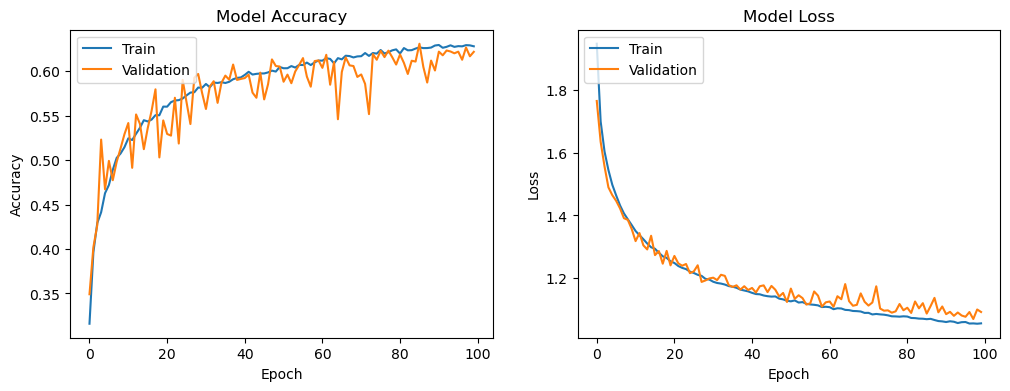

In [35]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Assuming r is the history object returned from model.fit()
plot_loss_accuracy(r)

In [ ]:
y_pred_prob = model_ResNet50.predict(valid_loader_tf)  # Predict probabilities
y_true = np.concatenate([y for x, y in valid_loader_tf], axis=0)  # True labels

# Compute ROC curve and ROC area for each class (assuming binary classification)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])  # For class 1
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

While the potential of performance of the ResNet50 model in our problem is very high, due to my computational resources I cannot provide the final training 

**Transfer learning :: ResNet50**


model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
